# **Imports**

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml

# **Plotter!**

In [268]:
def plotter(X, y):
  # Get unique labels and assign colors using a colormap
  x1 = X[:, 0]
  x2 = X[:, 1]

  data = {'x1' : x1, 'x2' : x2, 'Label': y}
  dfp = pd.DataFrame(data)

  unique_labels = dfp['Label'].unique()
  num_labels = len(unique_labels)

  # Use a colormap (e.g., 'viridis') to generate a list of colors
  color_map = plt.get_cmap('hsv')
  label_colors = {label: color_map(i / num_labels) for i, label in enumerate(unique_labels)}

  # Create a 3D scatter plot
  fig = plt.figure(figsize=(8, 6))

  # Scatter plot for each label
  for label, color in label_colors.items():
      subset = dfp[dfp['Label'] == label]
      plt.scatter(subset['x1'], subset['x2'], label=label, color=color, s=10)

  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.legend()
  plt.show()

# **Kernel PCA class**

In [269]:
class myKernelPCA:

  def __init__(self, n_components, kernel='rbf', gamma=None, degree=3, theta=1):
    self.n_components = n_components
    self.mean = None
    self.kernel = kernel
    self.gamma = gamma
    self.degree = degree
    self.theta = theta

    # Calculating the Kernel Matrix of the dataset
  def kernel_matrix(self, X1, X2):

    if self.gamma is None:      # If no gamma is set by the user
        self.gamma = 1.0 / X1.shape[1]
    if self.kernel == 'linear':
      return np.dot(X1, X2.T)
    elif self.kernel == 'rbf':
      return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2, axis=2)**2) # Calculating based on the rbf formula
    elif self.kernel == 'poly':
      return (np.dot(X1, X2.T) + self.theta)**self.degree
    elif self.kernel == 'sigmoid':
      return np.tanh(self.gamma * np.dot(X1, X2.T)+ self.theta)
    else:
      raise Exception("Accepted kernels: linear, poly, rbf, sigmoid")

  # Fitting the model
  def fit(self, X):

    self.X_fit = X
    n_samples = X.shape[0]

    # Finding the mean of the dataset and subtracting it from all elements / centering the data
    self.mean = np.mean(self.X_fit, axis=0)
    self.X_centered = X - self.mean

    # Building the covariance matrix based on the formula Cov(X,X) = (1/n)*sum((X-Xmean)(X-Xmean).T)
    kernel_matrix = self.kernel_matrix(self.X_centered, self.X_centered)

    # Centering the kernel matrix using the formula K - I_m.K - K.I_m + I_m.K.I_m
    id = np.zeros((n_samples, n_samples))     # Identity matrix
    np.fill_diagonal(id, 1)
    K_centered = kernel_matrix - np.dot(id, kernel_matrix) - np.dot(kernel_matrix, id) + np.dot(id, np.dot(kernel_matrix, id)) #kernel_matrix - ones.dot(kernel_matrix) - kernel_matrix.dot(ones) + ones.dot(kernel_matrix).dot(ones)

    # Finding the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(K_centered)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    eigenvectors = eigenvectors.T # linalg.eig returns column vectors but for easier calculations we need row vectors

    # Sorting eigenvalues in decreasing order. The eigenvector that corresponds to the largest eigenvalue is the first principal component an so on.
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[indices]

    self.components = eigenvectors[0:self.n_components] # Storing only up to n eigenvectors

  # Projecting the original data into the new n-dimensions
  def transform(self, X):
    X = self.kernel_matrix(X - np.mean(self.X_fit, axis=0), self.X_centered)
    return np.dot(X, self.components.T)

  def get_components(self):
    return self.components

# **LDA Class**

In [270]:
class LDA:

  def __init__(self, n_components):
    self.n_components = n_components
    self.linear_discriminants = None # Saving eigenvectors here

  def fit(self, X, y):
    n_features = X.shape[1]
    class_labels = np.unique(y)

    # Calculating within class and between class scatter matrices
    mean = np.mean(X, axis=0)
    S_W = np.zeros((n_features, n_features))
    S_B = np.zeros((n_features, n_features))
    for c in class_labels:
      X_c = X[y == c]
      mean_c = np.mean(X_c, axis=0) # S_W is sum(x-xc)*(x-xc).T
      S_W += (X_c - mean_c).T.dot(X_c - mean_c)
      n_c = X_c.shape[0]
      mean_diff = (mean_c - mean).reshape(n_features, 1) # S_B is sum(number_of_samples *(mean_of_class - mean)*(mean_of_class - mean).T)
      S_B += n_c * (mean_diff).dot(mean_diff.T)

    disc = np.linalg.inv(S_W).dot(S_B) # Applying the LDA formula of S_W^(-1) * S_B

    # Calculating eigenvalues and eigenvectors for disc matrix
    eigenvalues, eigenvectors = np.linalg.eig(disc)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    eigenvectors = eigenvectors.T
    indexes = np.argsort(abs(eigenvalues))[::-1] # Sorting by decreasing order
    eigenvalues = eigenvalues[indexes]
    eigenvectors = eigenvectors[indexes]
    self.linear_discriminants = eigenvectors[0:self.n_components]


  def transform(self, X):
    # Projecting data onto the new components
    return np.dot(X, self.linear_discriminants.T)

  def get_discriminants(self):
    return self.linear_discriminants

# **Star Type Classification**

**Pre-processing**

In [271]:
random_state = 1000
df = pd.read_csv("Stars.csv")

In [272]:
df = df.dropna()

In [273]:
y = df['Type']
X = df.drop('Type', axis=1)

In [274]:
# Turning colors and spectral class columns into unique int values
unique_values = X['Color'].unique()
mapping = {value: index + 1 for index, value in enumerate(unique_values)}
X['Color'] = X['Color'].map(mapping)
unique_values = X['Spectral_Class'].unique()
mapping = {value: index + 1 for index, value in enumerate(unique_values)}
X['Spectral_Class'] = X['Spectral_Class'].map(mapping)

In [275]:
scale = StandardScaler()
X_sc = scale.fit_transform(X)

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.4, random_state=random_state)

**Training model on all dimensions**

In [277]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [278]:
print(svm.score(X_train, y_train), svm.score(X_test, y_test), f1_score(y_test, y_pred, average='weighted'), svm.support_vectors_.shape)

0.9861111111111112 0.9583333333333334 0.9583200297999149 (96, 6)


**Training model after KPCA + LDA is applied**

In [279]:
kpca = myKernelPCA(4, kernel='sigmoid', degree=3)
kpca.fit(X_sc)
X_sc_proj = kpca.transform(X_sc)

In [280]:
lda = LDA(n_components=2)
lda.fit(X_sc_proj, y)
X_final = lda.transform(X_sc_proj)

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.4, random_state=random_state)

In [282]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [283]:
print(svm.score(X_train, y_train), svm.score(X_test, y_test), f1_score(y_test, y_pred, average='weighted'), svm.support_vectors_.shape)

0.9375 0.90625 0.9011642476875853 (129, 2)


**Visualizing data**

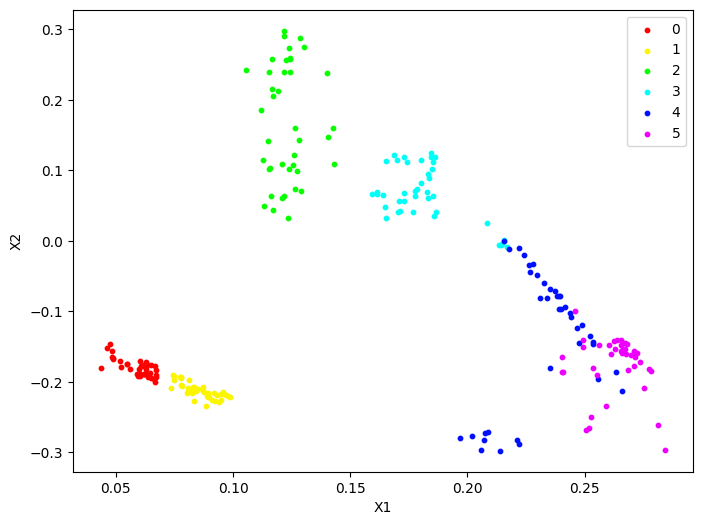

In [284]:
plotter(X_final, y)

# **Testing with sklearn**

In [285]:
skpca = KernelPCA(n_components=4, kernel='linear')
X_proj_sk = skpca.fit_transform(X_sc)
sklda = LinearDiscriminantAnalysis(n_components=2)
sklda.fit(X_proj_sk, y)
X_final_sk = sklda.transform(X_proj_sk)

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X_final_sk, y, test_size=0.4, random_state=random_state)

In [287]:
svm.fit(X_train, y_train)
y_pred_sk = svm.predict(X_test)
print(svm.score(X_train, y_train), svm.score(X_test, y_test), f1_score(y_test, y_pred_sk, average='weighted'))

0.9513888888888888 0.9270833333333334 0.9267342976617169


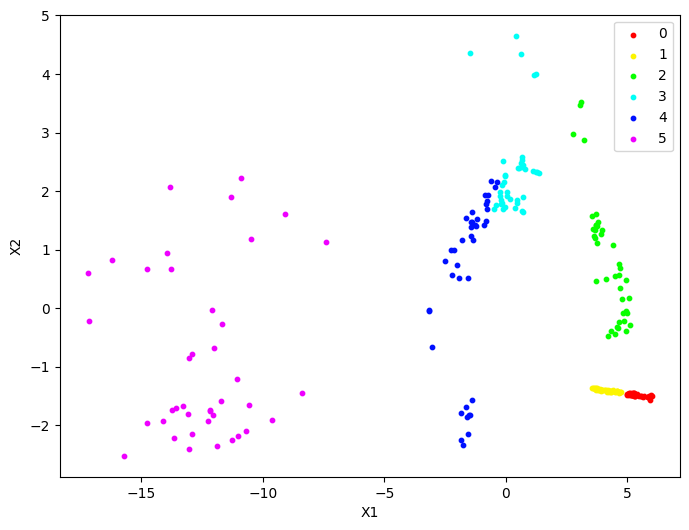

In [288]:
plotter(X_final_sk, y)

# **Cifar-10**

In [ ]:
cifar_10 = fetch_openml('CIFAR_10_small', cache=True)

In [290]:
# Extract features (X) and labels (y)
X = pd.DataFrame(cifar_10.data.astype('float32'))
y = pd.DataFrame(cifar_10.target.astype('int'))

# Reduce the dataset size for demonstration purposes
subset_size = 2000
X_subset = X[:subset_size]
y_subset = y[:subset_size]

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.4, random_state=random_state)

In [ ]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [293]:
print(svm.score(X_train, y_train), svm.score(X_test, y_test), f1_score(y_test, y_pred, average='weighted'), svm.support_vectors_.shape)

0.7708333333333334 0.38625 0.38125645689839405 (1184, 3072)


**KPCA + LDA**

In [294]:
kpca = KernelPCA(n_components = 1950, kernel = "cosine")
X_proj = kpca.fit_transform(X_subset)

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_final = lda.fit_transform(X_proj, y_subset)

**Re-training after Kernel PCA + LDA**

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_subset, test_size=0.4, random_state=random_state)

In [ ]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [298]:
print(svm.score(X_train, y_train), svm.score(X_test, y_test), f1_score(y_test, y_pred, average='weighted'), svm.support_vectors_.shape)

0.9716666666666667 0.96875 0.9684352732751361 (359, 2)


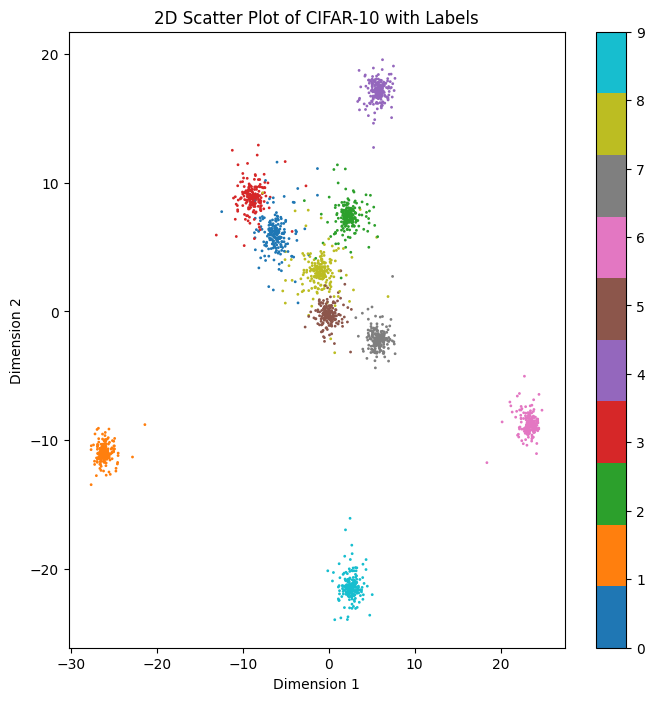

In [300]:
labels = y_subset.to_numpy()
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_final[:, 0], X_final[:, 1], c=labels, cmap='tab10', marker='o', s=1)
plt.colorbar(scatter)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Scatter Plot of CIFAR-10 with Labels')
plt.show()